In [151]:
import matplotlib.pyplot as plt
import itertools
import random
import copy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from operator import itemgetter
from itertools import groupby
%matplotlib inline

In [204]:
class Ring:
    def __init__(self, size, similarity_threshold = 0.5, neighbours_num = 1, races=2):
        self.size = size
        self.races = races
        self.similarity_threshold = similarity_threshold
        self.neighbours_num = neighbours_num
        self.race_ring = []
        self.satisfaction_ring = []
        self.neigh_size = 2*self.neighbours_num + 1 # size of nieghbourhood
        # CONSIDER SYSTEM WITH EMPTY SPOTS self.empty_ratio = empty_ratio
        self.populate()
        self.measure_satisfaction()

    def populate(self):
        #creates the self.ring structure - that's the initial and final thing we use
        #the current sustem assumes we are only working with two races, and half are 0, half 1
        #no empty spaces in this ring
        half = int(self.size/2)
        nodes = ([0]*half)+([1]*int(self.size - half))
        random.shuffle(nodes)
        self.race_ring = nodes

    def measure_satisfaction(self):
        self.satisfaction_ring = []
        for position in range(len(self.race_ring)):
            satisfaction = self.position_satisfaction(position)
            self.satisfaction_ring.append(satisfaction)  

    def get_neighbour_positions(self, position):
        neigh_pos = range(position-self.neighbours_num, position+self.neighbours_num+1)
        neigh_pos = list(map((lambda x: x%self.size), neigh_pos))
        return neigh_pos

    def get_neighbours(self, position):
        neigh_pos = self.get_neighbour_positions(position)
        neighbours = itemgetter(*neigh_pos)(self.race_ring)
        return neighbours

    def positional_percentage(self, position):
        point_race = self.race_ring[position]
        neighbours = self.get_neighbours(position)
        if point_race == 0:
            perc_same_race = neighbours.count(0)/self.neigh_size
        else:
            perc_same_race = neighbours.count(1)/self.neigh_size
        
        return perc_same_race

    def position_satisfaction(self, position):
        perc_same_race = self.positional_percentage(position)
        if perc_same_race>self.similarity_threshold:
            satisfaction = 1
        else:
            satisfaction = 0
        return satisfaction

    def opp_position_perc(self, position, other_swapper_position): 
        #the other swapper is for the case where something is swapping into the neighbourhood
        #which changed the neighbourhood - but its a change that hasn't yet happened
        #this is for when we decide to swap unsatisfied agents: we need to check if the new position
        #has a higher similarity than thier current position
        # but we need to account for the change in the neighbourhood they themselves cause
        point_race = self.race_ring[position]
        neighbours = self.get_neighbours(position)
        neighbour_positions = self.get_neighbour_positions(position) #room for potential efficiency here
        if other_swapper_position in neighbour_positions:
            #WE NEED SOMETHING HERE TO WORK OUT IF WORTH CHANGE
            if point_race == 0:
                perc_opp_race = (neighbours.count(1))/self.neigh_size #calculated if the swap had happened
            else: #point race is 1, so count how many 0's and add 1 due to the change
                perc_opp_race = (neighbours.count(0))/self.neigh_size            
        else:
            if point_race == 0:
                perc_opp_race = (neighbours.count(1)+1)/self.neigh_size #calculated if the swap had happened
            else: #point race is 1, so count how many 0's and add 1 due to the change
                perc_opp_race = (neighbours.count(0)+1)/self.neigh_size
        return perc_opp_race

    def get_unsat_pos(self):
        #HMM THIS COULD DEFINITELY BE MADE MORE EFFICIENT
        positions = [position for position, satisfaction in enumerate(self.satisfaction_ring) if satisfaction==0]
        race0_positions = [position for position, race in enumerate(self.race_ring) if race==0]
        race1_positions = [position for position, race in enumerate(self.race_ring) if race==1] ###
        positions_0 = list(set(positions) & set(race0_positions))
        positions_1 = list(set(positions) & set(race1_positions)) ###
        return positions_0, positions_1

    def update_neighbourhood(self, position):
        neighbour_positions = self.get_neighbour_positions(position)
        for neigh_position in neighbour_positions:
            satisfaction = self.position_satisfaction(neigh_position)
            self.satisfaction_ring[neigh_position] = satisfaction
    
    def swap(self, pos_0, pos_1):
        #we update our two rings of race and satisfaction
        #make the swap in the race_ring
        self.race_ring[pos_0] = 1
        self.race_ring[pos_1] = 0
        #now we need to update the satisfaction ring
        #to save computation we only want to update neighbourhood of swapped spots
        self.update_neighbourhood(pos_0)
        self.update_neighbourhood(pos_1)

    def swap_feasable(self, swap0, swap1):
        # long condition below is just : would each agent have 'better' neighbourhood after swap
        # in the sense of higher percentage same race
        curr_0_sat = self.positional_percentage(swap0)
        swap_0_sat = self.opp_position_perc(swap1, swap0)
        curr_1_sat = self.positional_percentage(swap1)
        swap_1_sat = self.opp_position_perc(swap0, swap1)
        #print('Curr0:', curr_0_sat, ' Swap0:', swap_0_sat)
        #print('Curr1:', curr_1_sat, ' Swap1:', swap_1_sat)
        if (curr_0_sat <= swap_0_sat) and (curr_1_sat <= swap_1_sat):
            return True
        else:
            return False
            
    def iteration(self):
        unsat0, unsat1 = self.get_unsat_pos()
        if unsat0 == [] or unsat1 == []:
            return 0 #We are using number to signify particular consequences
        else:
            swap0 = random.choice(unsat0)
            swap1 = random.choice(unsat1)
            if self.swap_feasable(swap0, swap1):
                self.swap(swap0, swap1)
                #print('swap made:', swap0, swap1)
                return 1
            else:
                #print('neither wants the swap')
                return 2
            
    def iteration_with_text(self):
        unsat0, unsat1 = self.get_unsat_pos()
        if unsat0 == [] or unsat1 == []:
            print('One race is entirely satisfied')
        else:
            swap0 = random.choice(unsat0)
            swap1 = random.choice(unsat1)
            # long condition below is just : would each agent have 'better' neighbourhood after swap
            # in the sense of higher percentage same race
            curr_0_sat = self.positional_percentage(swap0)
            swap_0_sat = self.opp_position_perc(swap1, swap0)
            curr_1_sat = self.positional_percentage(swap1)
            swap_1_sat = self.opp_position_perc(swap0, swap1)
            print('Curr0:', curr_0_sat, ' Swap0:', swap_0_sat)
            print('Curr1:', curr_1_sat, ' Swap1:', swap_1_sat)
            if (curr_0_sat <= swap_0_sat) and (curr_1_sat <= swap_1_sat):
                self.swap(swap0, swap1)
                print('swap made:', swap0, swap1)
                return True
            else:
                print('neither wants the swap')
                return False

    def check_stability(self):
        unsat_0, unsat_1 = self.get_unsat_pos()
        possible_swaps = 0
        if unsat_0==[] or unsat_1==[]:
            return possible_swaps
        else:
            for pos_0 in unsat_0:
                for pos_1 in unsat_1:
                    if self.swap_feasable(pos_0, pos_1):
                        #print('there is a feasable swap:', pos_0, pos_1)
                        possible_swaps += 1
            return possible_swaps

    def counting_streaks(self):
        lst = []
        for n,c in groupby(self.race_ring):
           num,count = n,sum(1 for i in c)
           lst.append((num,count))
        #dealing with the case we have a streak through the ends of the ring
        if (lst[0])[0] == (lst[-1])[0]:
            total_wrap_around = (lst[0])[1] + (lst[-1])[1]
            del lst[-1]
            lst[0] = ((lst[0])[0], total_wrap_around)
        #we might want to use segmented streaks later:
        streaks_0 = [streak[1] for streak in lst if streak[0]==0]
        streaks_1 = [streak[1] for streak in lst if streak[0]==1]
        streaks_total = streaks_0 + streaks_1
        return streaks_total        

In [205]:
def draw(ring):
    race = np.array([ring.race_ring])
    satisfaction = np.array([ring.satisfaction_ring])
    plt.figure(figsize=(10,5))
    #okay both binary and greyscal are doing things the flip way round. anoyingly
    plt.matshow(race, cmap=plt.cm.binary);
    plt.figure(figsize=(10,5))
    plt.matshow(satisfaction)
    plt.show()

populated
updated the whole satisfaction ring


<Figure size 720x360 with 0 Axes>

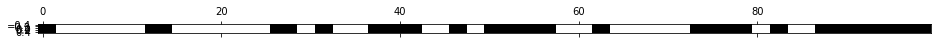

<Figure size 720x360 with 0 Axes>

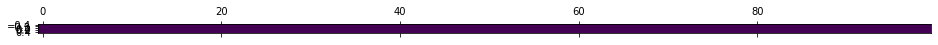

([10, 11, 2, 4, 3, 2, 4, 9, 2, 3, 15, 3, 3, 2, 6, 2, 8, 2, 7, 2],
 [10, 11, 2, 4, 3, 2, 4, 9, 2, 3],
 [15, 3, 3, 2, 6, 2, 8, 2, 7, 2])

In [190]:
london = Ring(100, 0.5, 1)
for i in range(10000):
    london.iteration()
    
draw(london)
london.counting_streaks()


In [224]:
(size_of_ring, neighbours, iterations) = (500, 10, 1000)
tolerance_levels = [0.05*i for i in range(21)]
#for tolerance_level in tolerance_levels:
tolerance_level = 0.67
streaks = []
for j in range(10):   
    ring = Ring(size_of_ring, tolerance_level, neighbours)
    while ring.check_stability()>2:
        for i in range(iterations):
            ring.iteration()
    streaks = streaks + ring.counting_streaks()
    print('next simulation')


[250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250]


(array([ 0.,  0.,  0.,  0.,  0., 20.,  0.,  0.,  0.,  0.]),
 array([249.5, 249.6, 249.7, 249.8, 249.9, 250. , 250.1, 250.2, 250.3,
        250.4, 250.5]),
 <a list of 10 Patch objects>)

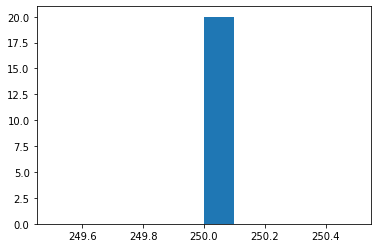

In [225]:
print(streaks)
plt.hist(streaks)


In [ ]:
def beginning_experimentation(size_of_ring, neighbours, iterations):
    tolerance_levels = [0.05*i for i in range(21)
    for tolerance_level in tolerance_levels:
        ring = Ring(size_of_ring, tolerance_level, neighbours)
        while ring.check_stability()>2:
            for i in range(iterations):
                ring.iteration()
        
        
    